In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import warnings
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")
from skimage import io, color, transform, feature, exposure
from my_measures import BinaryClassificationPerformance  
from sklearn.model_selection import train_test_split
%matplotlib inline

### IMPORTANT!!! Make sure you are using BinaryClassificationPerformance v1.03


In [2]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.03
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

### file paths and names

In [2]:
# file paths
ci_path = 'plane_data/cropped_images/'
l_file = 'plane_data/plane_labels.csv'

# Function for feature building and extraction on photographs¶

scikit-image documentation on methods used for feature extraction:  

* http://scikit-image.org/docs/dev/api/skimage.color.html#rgb2gray  
* http://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize  
* http://scikit-image.org/docs/stable/api/skimage.feature.html#skimage.feature.canny

# function to process raw images, resulting in training and test datasets

In [3]:
# function that takes raw images and completes all preprocessing required before model fits
def process_raw_data(labels_fn, images_fp, my_random_seed, imview=False, test=False):
    plane_data = pd.read_csv(labels_fn) # read in photograph labels
#     print("First few lines of image labels: ")
#     print(plane_data.head())
#     print("Size of image label dataFrame: ")
#     print(plane_data.shape)
        
    # construct lists for features, labels, and a crosswalk reference to image names
    features_list = []
    if (not test):
        y_list = []
    imnames_list = []

    for index, row in plane_data.iterrows():
        features_list.append(image_manipulation(row['img_name'], images_fp))
        if (not test):
            y_list.append(row['plane'])
        imnames_list.append(row['img_name'])
    
    # convert the lists to ndarrays
    features = np.asarray(features_list)
    if (not test):
        Y = np.asarray(y_list)
    imgs = np.asarray(imnames_list)
#     print('Shape of original feature representation: ')
#     print(features.shape)

    # flatten the images ndarray to one row per image
    features_flat = features.reshape((features.shape[0], -1))

#     print('Shape of flat feature representation: ')
#     print(features_flat.shape)

    if (not test):
#         print('Shape of Y: ')
#         print(Y.shape)

#         print('Number of images with planes: ')
#         print(Y.sum())
    
        # create train and test sets
        data_train, data_test, y_train, y_test, imgs_train, imgs_test = train_test_split(features_flat, 
            Y, imgs, test_size = 0.25, random_state = my_random_seed)

#         print('Shape of training set: ')
#         print(y_train.shape)
#         print('Number of training images that contain an airplane: ')
#         print(y_train.sum())

#         print('Shape of test set: ')
#         print(y_test.shape)
#         print('Number of test images that contain an airplane: ')
#         print(y_test.sum())
    
    if (test):
        X_submission_test = features_flat
#         print("Shape of X_test for submission:")
#         print(X_submission_test.shape)
#         print('SUCCESS!')
        return(X_submission_test, plane_data)
    else: 
#         print("Shape of data_train and data_test:")
#         print(data_train.shape)
#         print(data_test.shape)
#         print("Shape of y_train and y_test:")
#         print(y_train.shape)
#         print(y_test.shape)
#         print("Shape of imgs_train and imgs_test:")
#         print(imgs_train.shape)
#         print(imgs_test.shape)
#         print('SUCCESS!')
        return(data_train, data_test, y_train, y_test, imgs_train, imgs_test)


## Image Transformation using Canny Edge Detector

In [7]:
# Set dimension to (15, 35)

from sklearn import neural_network

dims = (15,35)

# set dfs 
nn = {}
nn_performance = {}
nn_performance_test = {}
nn_img_indices_to_view = {}

# set sigmas

sigmas = (1, 1.15, 1.2, 1.25, 1.35)

for i in range(5): 

    def image_manipulation(imname, imgs_path, imview=False):
        warnings.filterwarnings('ignore')
        imname = imgs_path + imname + '.png'
        img_raw = io.imread(imname, as_gray=True)
        downscaled = transform.resize(img_raw, (dims[0], dims[1])) # downscale image
        final_image = feature.canny(downscaled, sigma=sigmas[i]) # edge filter image with Canny algorithm
        if imview==True:
            io.imshow(final_image)
        warnings.filterwarnings('always')
        return final_image

    # Process and split train/test data
    data_train, data_test, y_train, y_test, imgs_train, imgs_test = process_raw_data(l_file, ci_path, 
        my_random_seed=99, imview=False, test=False)

    # Apply Neural Network Models for train/test
    nn[i] = neural_network.MLPClassifier(max_iter=1000)
    nn[i].fit(data_train, y_train)

    nn_performance[i] = BinaryClassificationPerformance(nn[i].predict(data_train), y_train, ('nn'+str(sigmas[i])))
    nn_performance[i].compute_measures()
    nn_performance[i].performance_measures['set'] = 'train'
    print('TRAINING SET: ')
    print(nn_performance[i].performance_measures)

    nn_performance_test[i] = BinaryClassificationPerformance(nn[i].predict(data_test), y_test, ('nn'+str(sigmas[i])))
    nn_performance_test[i].compute_measures()
    nn_performance_test[i].performance_measures['set'] = 'test'
    print('TEST SET: ')
    print(nn_performance_test[i].performance_measures)
    
    print('* * * * *')

    nn_performance_test[i].img_indices()
    nn_img_indices_to_view[i] = nn_performance_test[i].image_indices

TRAINING SET: 
{'Pos': 80, 'Neg': 4988, 'TP': 80, 'TN': 4988, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'nn1', 'set': 'train'}
TEST SET: 
{'Pos': 21, 'Neg': 1669, 'TP': 12, 'TN': 1669, 'FP': 0, 'FN': 9, 'Accuracy': 0.9946745562130177, 'Precision': 1.0, 'Recall': 0.5714285714285714, 'desc': 'nn1', 'set': 'test'}
* * * * *
TRAINING SET: 
{'Pos': 80, 'Neg': 4988, 'TP': 80, 'TN': 4988, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'nn1.15', 'set': 'train'}
TEST SET: 
{'Pos': 21, 'Neg': 1669, 'TP': 13, 'TN': 1668, 'FP': 1, 'FN': 8, 'Accuracy': 0.9946745562130177, 'Precision': 0.9285714285714286, 'Recall': 0.6190476190476191, 'desc': 'nn1.15', 'set': 'test'}
* * * * *
TRAINING SET: 
{'Pos': 80, 'Neg': 4988, 'TP': 80, 'TN': 4988, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'nn1.2', 'set': 'train'}
TEST SET: 
{'Pos': 21, 'Neg': 1669, 'TP': 11, 'TN': 1668, 'FP': 1, 'FN': 10, 'Accuracy': 0.99349112426

## Image transformation using Histogram of oriented gradients (HOG)

In [15]:
# modules 
from sklearn import neural_network
from skimage.feature import hog

# set dfs 
nnh = {}
nnh_performance = {}
nnh_performance_test = {}
nnh_img_indices_to_view = {}

for i in range(1): 

    def image_manipulation(imname, imgs_path, imview=False):
        warnings.filterwarnings('ignore')
        imname = imgs_path + imname + '.png'
        img_raw = io.imread(imname, as_gray=True)
        downscaled = transform.resize(img_raw, (dims[0], dims[1])) # downscale image
        fd, hog_image = hog(img_raw, orientations=8, pixels_per_cell=(10, 10),
                      cells_per_block=(2, 2), visualize=True) 
        final_image = np.array([hog_image])
        if imview==True:
            io.imshow(final_image)
        warnings.filterwarnings('always')
        return final_image

    # Process and split train/test data
    data_train, data_test, y_train, y_test, imgs_train, imgs_test = process_raw_data(l_file, ci_path, 
        my_random_seed=99, imview=False, test=False)

    # Apply Neural Network Models for train/test
    nnh[i] = neural_network.MLPClassifier(max_iter=1000)
    nnh[i].fit(data_train, y_train)

    nnh_performance[i] = BinaryClassificationPerformance(nnh[i].predict(data_train), y_train, ('hog'+str([i])))
    nnh_performance[i].compute_measures()
    nnh_performance[i].performance_measures['set'] = 'train'
    print('TRAINING SET: ')
    print(nnh_performance[i].performance_measures)

    nnh_performance_test[i] = BinaryClassificationPerformance(nnh[i].predict(data_test), y_test, ('hog'+str([i])))
    nnh_performance_test[i].compute_measures()
    nnh_performance_test[i].performance_measures['set'] = 'test'
    print('TEST SET: ')
    print(nnh_performance_test[i].performance_measures)
    
    print('* * * * *')

    nnh_performance_test[i].img_indices()
    nnh_img_indices_to_view[i] = nnh_performance_test[i].image_indices

TRAINING SET: 
{'Pos': 80, 'Neg': 4988, 'TP': 80, 'TN': 4988, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'hog[0]', 'set': 'train'}
TEST SET: 
{'Pos': 21, 'Neg': 1669, 'TP': 19, 'TN': 1669, 'FP': 0, 'FN': 2, 'Accuracy': 0.9988165680473373, 'Precision': 1.0, 'Recall': 0.9047619047619048, 'desc': 'hog[0]', 'set': 'test'}
* * * * *


## Performance Plots

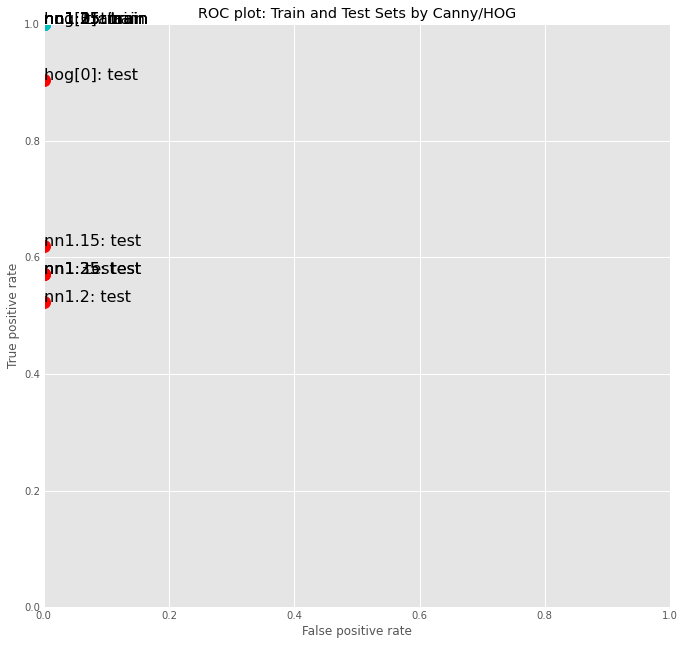

In [16]:
# HOG Performance Plot 
final_fits = []

for i in range(5):
    final_fits.append(nn_performance[i].performance_measures)
    final_fits.append(nn_performance_test[i].performance_measures)

final_fits.append(nnh_performance[0].performance_measures)
final_fits.append(nnh_performance_test[0].performance_measures)

# show figure 

plt.figure(figsize=(10,10))
plt.style.use('fivethirtyeight')
plt.style.use('ggplot')

for fit in final_fits:
    if fit['set'] == 'train':
        color = 'co'
    else:
        color = 'ro'
    plt.plot(fit['FP'] / fit['Neg'], 
             fit['TP'] / fit['Pos'], color, markersize=12)
    plt.text(fit['FP'] / fit['Neg'], 
             fit['TP'] / fit['Pos'], fit['desc'] + ': ' + fit['set'], fontsize=16)
plt.axis([0,1,0,1])
plt.title('ROC plot: Train and Test Sets by Canny/HOG')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

Text(0.5, 1.0, 'Compare True Positive Rates for Test Set')

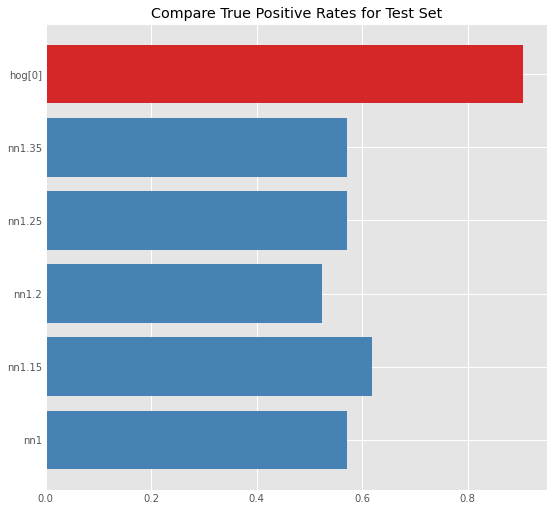

In [17]:
plt.figure(figsize=(8,8))

for i in range(5):
    plt.barh(nn_performance_test[i].performance_measures['desc'], 
            nn_performance_test[i].performance_measures['TP']/nn_performance_test[i].performance_measures['Pos'], 
             color='steelblue')

plt.barh(nnh_performance_test[0].performance_measures['desc'], 
         nnh_performance_test[0].performance_measures['TP']/nn_performance_test[i].performance_measures['Pos'], 
         color='tab:red')
    
plt.title('Compare True Positive Rates for Test Set')

---

# Summary of work and performance  

I made feature alterations to the images using the Canny Edge Detector and Histogram of Oriented Gradients (HOG) methods in scikit learn.

**Canny Edge Detector**: With Canny, I tested a number of different sigma values altering the Gaussian filter. The final work used five different sigma values of "1, 1.15, 1.2, 1.25, 1.35" to find the best performance alteration. In all cases, the train set performances were 100%. However, the test set performance ranged from around **0.45 to 0.62 for the True Positive Rates**. The best performance was with the **Sigma set at 1.15**. The performance didn't improve even when changing the dimension size for the rescaling or significantly increasing or decreasing the sigma values. There seems to be some limits to the test set TP performance.  

**HOG transformation**: I only tested one variation for the HOG method with parameters set at "hog(img_raw, orientations=8, pixels_per_cell=(10, 10), cells_per_block=(2, 2), visualize=True)." The HOG resulted in 100% for the train set and also a high performance of 0 false positive rate and a **0.9 true positive rate**. This seems to suggest potential of optimizing and using HOG for future iterations. 

